# Microsoft Stock Price Prediction

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
import matplotlib.dates as mdates
from scipy.stats import pearsonr

from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM

import yfinance as yf

### Import Data

In [2]:
msft = yf.download("MSFT")

[*********************100%***********************]  1 of 1 completed


### Normalize the Data (between 0 and 1)

In [3]:
msft_norm = msft.copy()
scaler = MinMaxScaler(feature_range = (0,1))
msft_norm[['Open', 'High', 'Low', 'Adj Close']] = scaler.fit_transform(msft_norm[['Open', 'High', 'Low', 'Adj Close']])
msft_norm.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-13,0.000000,0.000027,0.000000,0.097222,0.000013,1031788800
1986-03-14,0.000025,0.000030,0.000025,0.100694,0.000019,308160000
1986-03-17,0.000035,0.000032,0.000036,0.102431,0.000022,133171200
1986-03-18,0.000040,0.000032,0.000030,0.099826,0.000018,67766400
1986-03-19,0.000033,0.000025,0.000025,0.098090,0.000014,47894400


# 1) Predicting tomorrow's closing price

In [4]:
features = ['Open', 'High', 'Low', 'Adj Close']

def offset_table(df, days):
    # Input: dataframe and days 
    # Output: The same dataframe, but with an extra Y column. The Y column is 'Adj Close' from the same table, but n days in advance

    x_temp = df[:-days].reset_index()
    y_temp = df[days:].reset_index()['Adj Close']

    result = x_temp.join(y_temp, rsuffix='Y')
    result.rename({'Adj CloseY':'Y'}, axis='columns', inplace=True)
    return result

In [24]:
msft_offset = offset_table(msft_norm, 1)

In [6]:
# Pearson R coefficient
col_name = 'Open'
pearsonr(msft_offset[col_name], msft_offset['Y'])

PearsonRResult(statistic=0.9978021441064926, pvalue=0.0)

    The above cell calculates the Pearson R coefficient between OHLC and Adj Close for the next day. As expected, there is a strong correlation between the yesterday's OHLC numbers and tomorrow's closing stock prices

### Split into train and test

In [7]:
def train_test_split(df, train_ratio):
    # Input: Takes df; table and train_ratio; an int between 0 and 1 representing the ratio of train:test

    train_rows = round(df.shape[0] * train_ratio) # num of rows to train vs test
    
    train = df.iloc[0:train_rows, :]  # Splitting the data
    test = df.iloc[train_rows::, :]
    X_train, Y_train = train[features], train['Y']
    X_test, Y_test = test[features], test['Y']
    
    X_train = np.array(X_train) # Reformat
    X_test = np.array(X_test)

    X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    
    return X_tr_t, Y_train, X_tst_t, Y_test

In [8]:
split_ratio = 0.7
X_train, Y_train, X_test, Y_test = train_test_split(msft_offset, split_ratio)

### Build Model
    Input layer -> Hidden Layer (16 Nodes) -> Output layer.

In [9]:
K.clear_session()
model = Sequential()
model.add(LSTM(16, input_shape=(1, X_train.shape[2]), activation='relu', return_sequences=False))
model.add(Dense(1)) 
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)

In [10]:
model.fit(X_train, Y_train, epochs=50, batch_size=8, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/50
813/813 [==============================] - 1s 689us/step - loss: 1.5024e-05
Epoch 2/50
813/813 [==============================] - 1s 693us/step - loss: 3.1117e-05
Epoch 3/50
813/813 [==============================] - 1s 685us/step - loss: 3.0826e-05
Epoch 4/50
813/813 [==============================] - 1s 682us/step - loss: 2.0212e-05
Epoch 5/50
813/813 [==============================] - 1s 682us/step - loss: 1.8970e-05
Epoch 6/50
813/813 [==============================] - 1s 681us/step - loss: 1.0821e-05
Epoch 7/50
813/813 [==============================] - 1s 686us/step - loss: 1.1044e-05
Epoch 8/50
813/813 [==============================] - 1s 682us/step - loss: 5.5991e-06
Epoch 9/50
813/813 [==============================] - 1s 686us/step - loss: 6.0150e-06
Epoch 10/50
813/813 [==============================] - 1s 687us/step - loss: 3.7037e-06
Epoch 11/50
813/813 [==============================] - 1s 690us/step - loss: 4.5243e-06
Epoch 12/50
813/813 [====================

In [11]:
Y_train_pred = model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(Y_train, Y_train_pred)))
r2_train = r2_score(Y_train, Y_train_pred)

Y_test_pred = model.predict(X_test)
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(Y_test, Y_test_pred)))
r2_test = r2_score(Y_test, Y_test_pred)

204/204 [==============================] - 0s 488us/step
The R2 score on the Train set is:	0.835
88/88 [==============================] - 0s 495us/step
The R2 score on the Test set is:	0.818


In [12]:
loss = model.evaluate(X_test, Y_test, batch_size=1)

2786/2786 [==============================] - 1s 464us/step - loss: 0.0130


C:\Users\Kenta Sakai\AppData\Local\Temp\ipykernel_27228\1943297921.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Y_pred'] = Y_test_pred


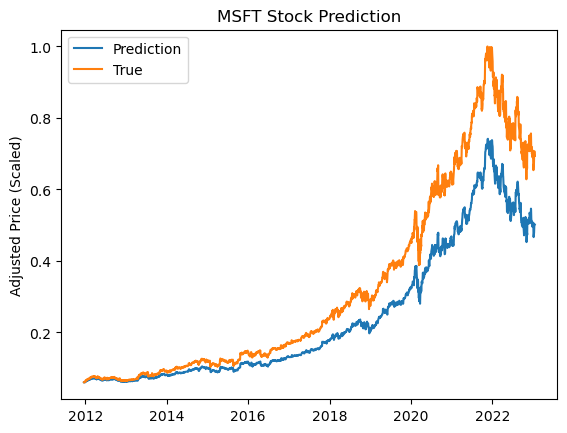

In [13]:
# Add Y_test_pred to  
train_rows = round(msft_offset.shape[0] * split_ratio)
final_df = msft_offset.iloc[train_rows::, :]
final_df['Y_pred'] = Y_test_pred

# Plot
plt.plot(final_df['Date'], final_df['Y_pred'], label = 'Prediction')
plt.plot(final_df['Date'], final_df['Y'], label = 'True')
plt.title("MSFT Stock Prediction")
plt.ylabel('Adjusted Price (Scaled)')
plt.legend()
plt.show()

    The prediction is good at forecasting the stock price patterns, but tend to undervalue the stocks. This trend gets worse as time goes on, which is reasonable because it is a time series prediction. Because we are using the earliest 70% of the data to train the model, as we move further into the future, the less the training data reflects the test data, and so we see greater variance like the plot above.

# 2) Predicting next week's closing price 

In [14]:
msft_offset = offset_table(msft_norm, 5) # offset data by 5 days
X_train, Y_train, X_test, Y_test = train_test_split(msft_offset, split_ratio)

In [15]:
model.fit(X_train, Y_train, epochs=50, batch_size=8, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/50
813/813 [==============================] - 1s 690us/step - loss: 7.8720e-06
Epoch 2/50
813/813 [==============================] - 1s 689us/step - loss: 9.6287e-06
Epoch 3/50
813/813 [==============================] - 1s 685us/step - loss: 1.1573e-05
Epoch 4/50
813/813 [==============================] - 1s 689us/step - loss: 1.0244e-05
Epoch 5/50
813/813 [==============================] - 1s 692us/step - loss: 1.1171e-05
Epoch 6/50
813/813 [==============================] - 1s 688us/step - loss: 1.0873e-05
Epoch 7/50
813/813 [==============================] - 1s 690us/step - loss: 1.0758e-05
Epoch 8/50
813/813 [==============================] - 1s 703us/step - loss: 1.1434e-05
Epoch 9/50
813/813 [==============================] - 1s 693us/step - loss: 1.0787e-05
Epoch 10/50
813/813 [==============================] - 1s 698us/step - loss: 1.0616e-05
Epoch 11/50
813/813 [==============================] - 1s 698us/step - loss: 1.0247e-05
Epoch 11: early stopping


In [16]:
Y_train_pred = model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(Y_train, Y_train_pred)))
r2_train = r2_score(Y_train, Y_train_pred)

Y_test_pred = model.predict(X_test)
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(Y_test, Y_test_pred)))
r2_test = r2_score(Y_test, Y_test_pred)

204/204 [==============================] - 0s 498us/step
The R2 score on the Train set is:	0.636
88/88 [==============================] - 0s 495us/step
The R2 score on the Test set is:	0.253


In [17]:
loss = model.evaluate(X_test, Y_test, batch_size=1)

2785/2785 [==============================] - 1s 480us/step - loss: 0.0533


C:\Users\Kenta Sakai\AppData\Local\Temp\ipykernel_27228\1943297921.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Y_pred'] = Y_test_pred


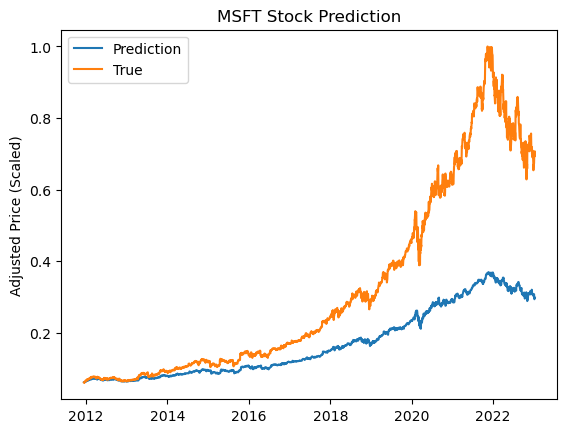

In [18]:
# Add Y_test_pred to  
train_rows = round(msft_offset.shape[0] * split_ratio)
final_df = msft_offset.iloc[train_rows::, :]
final_df['Y_pred'] = Y_test_pred

# Plot
plt.plot(final_df['Date'], final_df['Y_pred'], label = 'Prediction')
plt.plot(final_df['Date'], final_df['Y'], label = 'True')
plt.title("MSFT Stock Prediction")
plt.ylabel('Adjusted Price (Scaled)')
plt.legend()
plt.show()

    Predicting stock prices one week in the future is a bit more difficult. The issue we saw previously is more pronounced, but  the model is still able to predicts patterns accurately.

# 3) Predicting  Up or Down

In [128]:
msft_up = msft_offset.copy() # msft_offset with additional Up? column. True if stock price went up, false if not.
msft_up['Up?'] = msft_offset['Y'] >= msft_offset['Adj Close']
msft_up["Up?"] = msft_up["Up?"].astype(int)

In [94]:
def tt_split(df, train_ratio):
    # Train_ratio is an int between 0 and 1 representing the train test spilt ratio
    train_rows = round(df.shape[0] * train_ratio) # num of rows to train vs test
    
    train = df.iloc[0:train_rows, :]  # Splitting the data
    test = df.iloc[train_rows::, :]
    X_train, Y_train = train[features], train['Up?']
    X_test, Y_test = test[features], test['Up?']
    
    X_train = np.array(X_train) # Reformat
    X_test = np.array(X_test)

    X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    
    return X_tr_t, Y_train, X_tst_t, Y_test

X_train, Y_train, X_test, Y_test = tt_split(msft_up, split_ratio)

In [129]:
K.clear_session()
model = Sequential()
model.add(Dense(8, activation='relu', input_shape=(1, X_train.shape[2])))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics = 'accuracy')
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)

model.fit(X_train, Y_train, epochs=50, batch_size=8, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/50
813/813 [==============================] - 1s 581us/step - loss: 0.6919 - accuracy: 0.5259
Epoch 2/50
813/813 [==============================] - 0s 583us/step - loss: 0.6913 - accuracy: 0.5258
Epoch 3/50
813/813 [==============================] - 0s 579us/step - loss: 0.6913 - accuracy: 0.5258
Epoch 4/50
813/813 [==============================] - 0s 581us/step - loss: 0.6913 - accuracy: 0.5256
Epoch 5/50
813/813 [==============================] - 0s 582us/step - loss: 0.6912 - accuracy: 0.5255
Epoch 6/50
813/813 [==============================] - 0s 579us/step - loss: 0.6912 - accuracy: 0.5264
Epoch 7/50
813/813 [==============================] - 0s 584us/step - loss: 0.6912 - accuracy: 0.5264
Epoch 8/50
813/813 [==============================] - 0s 587us/step - loss: 0.6911 - accuracy: 0.5244
Epoch 9/50
813/813 [==============================] - 0s 583us/step - loss: 0.6912 - accuracy: 0.5259
Epoch 10/50
813/813 [==============================] - 0s 571us/step - loss: 0.691

In [127]:
y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test,verbose=1)

88/88 [==============================] - 0s 529us/step - loss: 0.8055 - accuracy: 0.4684
